# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)



In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'

tmpdir = tempfile.mkdtemp()


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [3]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [5]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [6]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [7]:
def get_data(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [8]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [9]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 
<br> Unfortunately, when using a pretrained model, one is limited by input_shape. For VGG16, it should be (224, 244, 3), or (3, 224, 224). It should be in 4D tensor with shape (batch_shape, conv_dim1, conv_dim2, channel).


In [10]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130, 256, 256, 3) for train
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [ ]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [13]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [14]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [15]:
image = np.load('data/train_transform/sagittal.npy')
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [16]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [17]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [18]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [19]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [20]:
def data_gen(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

In [21]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [22]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


## Utilising pretrained model

### VGG


The VGG model was created by [Oxford Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG), which helped fueled transfer learning work on new predictive modeling tasks.

Despite winning the ImageNet challenge in 2014, the VGG models (VGG16, VGG19) are no longer considered state-of-the-art. However, they are still powerful pre-trained models that are useful as the basis to build better predictive image classifiers, and a good foundation for this project.


In [23]:
model = VGG16()

# display architecture
print(model.summary())


553476096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

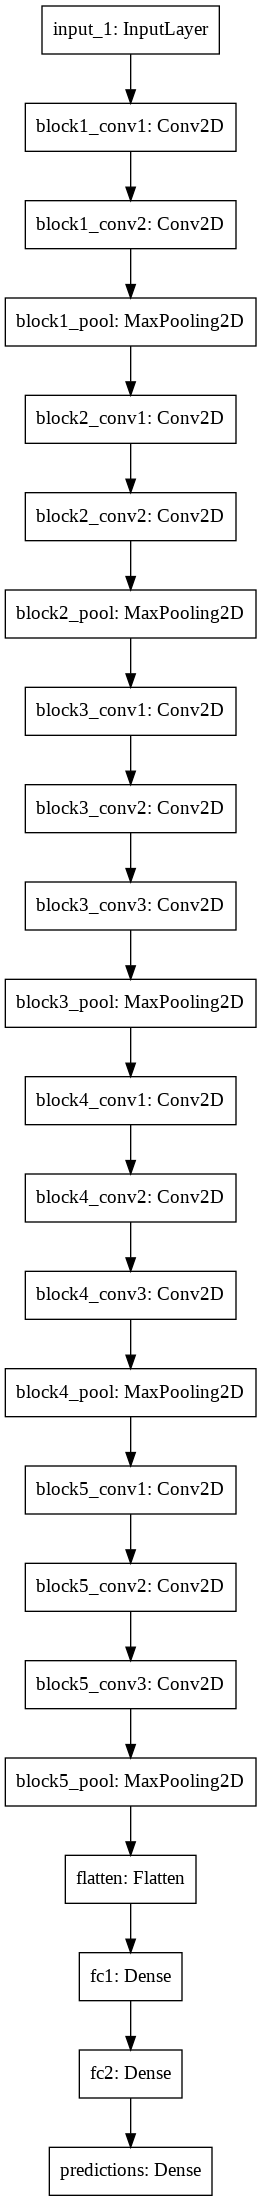

In [24]:
plot_model(model, to_file='vgg.png')


In [25]:
# https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
image = load_img('/content/drive/MyDrive/knee0000.png',target_size=(224,224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))


49152/35363 [=========================================] - 0s 0us/step
lampshade (59.64%)


Note that VGG16 has no class 'knee', so a random image was identified as a lampshade.

**VGG16 model**

'include_top' argument is False, so that the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained. 
Since 'include_top' argument is False, the 'input_tensor' argument must be specified, allowing the expected fixed-sized input of the model to be changed. 
Since there is no output layer, the 'pooling' argument will take the average output from the last layer directly. 


In [26]:
def finetune_model(model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function builds and runs the model'''
    # path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    # weights_path = f'{path_dir}\{model_name}\\add_weights.h5'
    path_dir = '/content/drive/MyDrive' 
    weights_path = f'{path_dir}/{model_name}/new_weights.h5'
    
    new_input = Input(shape=(256, 256, 3))
    model = VGG16(weights='imagenet', include_top=False, input_tensor=new_input)
    
    add_model = Sequential()
    add_model.add(Flatten(input_shape=model.output_shape[1:]))
    add_model.add(Dense(64, activation='relu'))
    add_model.add(Dropout(0.5))
    add_model.add(Dense(1, activation='sigmoid'))
#     add_model.load_weights(weights_path)
    
    final_model = Model(inputs=model.input, outputs=add_model(model.output))
    final_model.save_weights(weights_path)
    
    # weights will not be updated
    for layer in model.layers[:15]:
        layer.trainable = False
        
    sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=False)
    final_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = final_model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min')],                  
            verbose=1)
    
    return final_model, history

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/20
36/36 [==============================] - 45s 800ms/step - loss: 2.4225 - accuracy: 0.5743 - val_loss: 0.6844 - val_accuracy: 0.5667
Epoch 2/20
36/36 [==============================] - 13s 367ms/step - loss: 0.6611 - accuracy: 0.6398 - val_loss: 0.6936 - val_accuracy: 0.5667
Epoch 3/20
36/36 [==============================] - 13s 368ms/step - loss: 0.6520 - accuracy: 0.6460 - val_loss: 0.6893 - val_accuracy: 0.5667
Epoch 4/20
36/36 [==============================] - 13s 366ms/step - loss: 0.6557 - accuracy: 0.6487 - val_loss: 0.6952 - val_accuracy: 0.5667


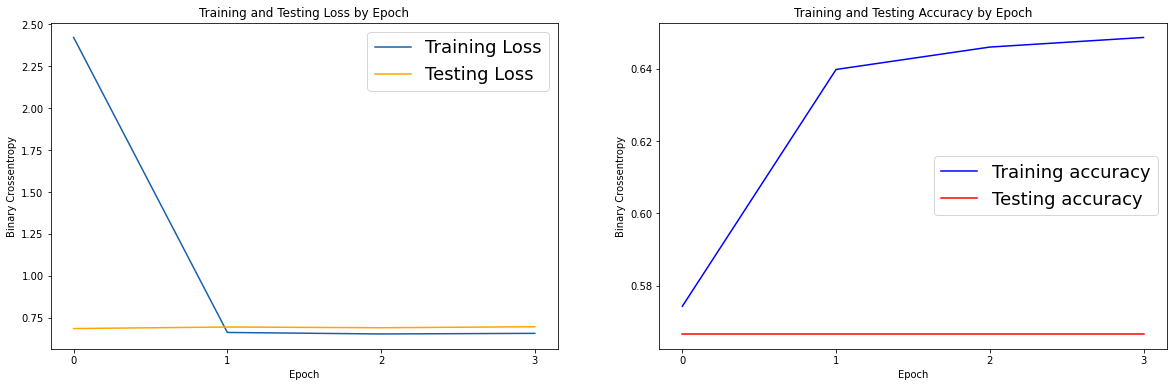

In [27]:
# coronal plane
num_epochs=20

cor_men_model, vgg_cor_men = finetune_model('vgg_cor_men', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
vgg_cor_men_acc=[]
vgg_cor_men_acc.append(np.mean(vgg_cor_men.history['val_accuracy']))
plot_results(vgg_cor_men)

Epoch 1/10
36/36 [==============================] - 14s 375ms/step - loss: 1.5001 - accuracy: 0.6124 - val_loss: 0.6858 - val_accuracy: 0.5833
Epoch 2/10
36/36 [==============================] - 13s 367ms/step - loss: 0.6648 - accuracy: 0.6319 - val_loss: 0.7065 - val_accuracy: 0.5667
Epoch 3/10
36/36 [==============================] - 13s 367ms/step - loss: 0.6702 - accuracy: 0.6336 - val_loss: 0.7002 - val_accuracy: 0.5667
Epoch 4/10
36/36 [==============================] - 13s 367ms/step - loss: 0.6633 - accuracy: 0.6363 - val_loss: 0.7106 - val_accuracy: 0.5667


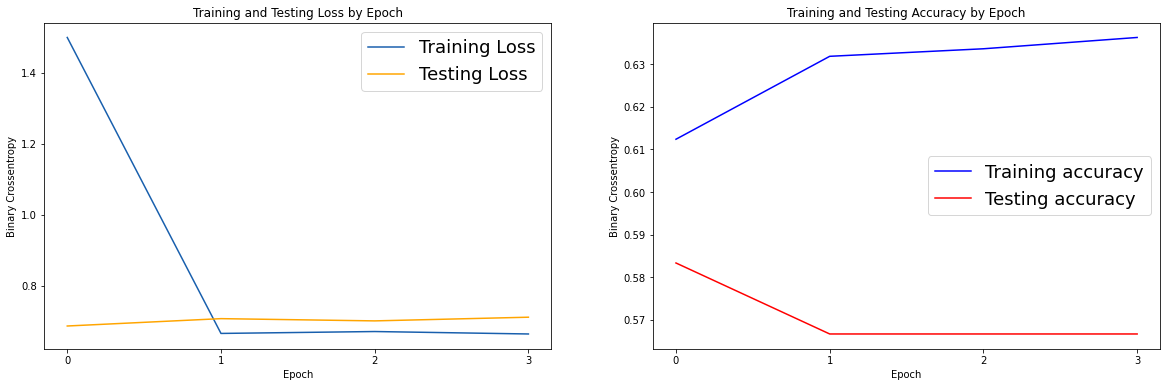

In [28]:
# axial plane
num_epochs=10

axl_men_model, vgg_axl_men = finetune_model('vgg_axl_men', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
vgg_axl_men_acc=[]
vgg_axl_men_acc.append(np.mean(vgg_axl_men.history['val_accuracy']))
plot_results(vgg_axl_men)

In [29]:
df = pd.DataFrame(([layer.name, layer.trainable] for layer in cor_men_model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"yellow" if trainable else "white"}', subset=['trainable'])

,layer,trainable
0,input_2,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


The above table just shows that the last conv layer of vgg16, and the added output layers were being trained. 

Epoch 1/10
36/36 [==============================] - 15s 375ms/step - loss: 1.4249 - accuracy: 0.5779 - val_loss: 0.7028 - val_accuracy: 0.5583
Epoch 2/10
36/36 [==============================] - 13s 368ms/step - loss: 0.6656 - accuracy: 0.6336 - val_loss: 0.6984 - val_accuracy: 0.5667
Epoch 3/10
36/36 [==============================] - 13s 367ms/step - loss: 0.6634 - accuracy: 0.6301 - val_loss: 0.6910 - val_accuracy: 0.5667
Epoch 4/10
36/36 [==============================] - 13s 368ms/step - loss: 0.6686 - accuracy: 0.6381 - val_loss: 0.6905 - val_accuracy: 0.5583
Epoch 5/10
36/36 [==============================] - 13s 367ms/step - loss: 0.6617 - accuracy: 0.6513 - val_loss: 0.6856 - val_accuracy: 0.5667
Epoch 6/10
36/36 [==============================] - 13s 368ms/step - loss: 0.6534 - accuracy: 0.6425 - val_loss: 0.6916 - val_accuracy: 0.5667
Epoch 7/10
36/36 [==============================] - 13s 367ms/step - loss: 0.6555 - accuracy: 0.6460 - val_loss: 0.6983 - val_accuracy: 0.5583

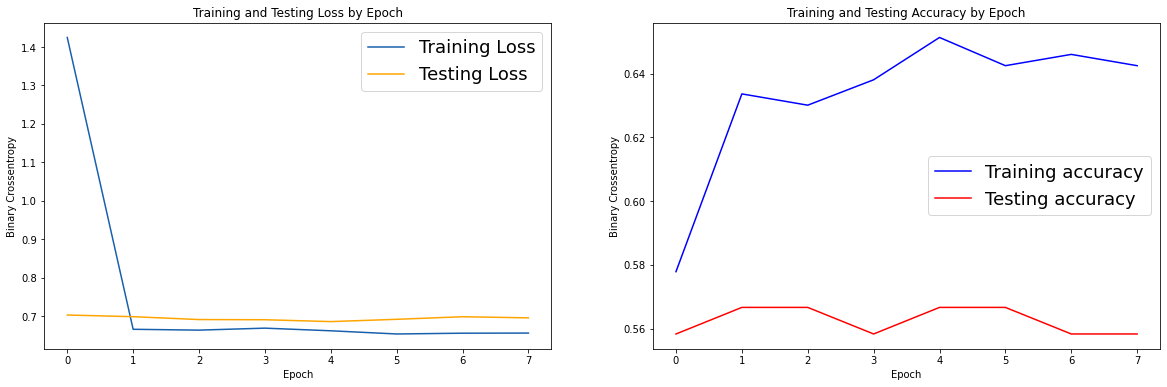

In [30]:
# sagittal plane
num_epochs=10

sag_men_model, vgg_sag_men = finetune_model('vgg_sag_men', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
vgg_sag_men_acc=[]
vgg_sag_men_acc.append(np.mean(vgg_sag_men.history['val_accuracy']))
plot_results(vgg_sag_men)

**calculate average accuracy**

In [31]:
[vgg_cor_men_acc, vgg_axl_men_acc, vgg_sag_men_acc]

[[0.5666666626930237], [0.5708333253860474], [0.5625]]

### Evaluate results

In [32]:
cor_men_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cor_men_scores[0]) 
print('Test accuracy:', cor_men_scores[1])

Test loss: 0.6951507329940796
Test accuracy: 0.5666666626930237


In [33]:
cor_pred = cor_men_model.predict(coronal_mensicus_val) 
axl_pred = axl_men_model.predict(axial_mensicus_val) 
sag_pred = sag_men_model.predict(sagittal_mensicus_val) 

In [34]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [35]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0      0.385601
1      0.357506
2      0.380887
3      0.388541
4      0.371577
         ...   
115    0.380471
116    0.384996
117    0.368260
118    0.376162
119    0.352918
Name: mean, Length: 120, dtype: float32

In [36]:
pred_men['mean'] = pred_men.mean(axis=1)

In [37]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [38]:
pred_men['predict'].value_counts()

0    120
Name: predict, dtype: int64

In [39]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label_val

In [40]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(52, 6)

In [41]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
42,0.355652,0.358743,0.416108,0.376834,0,1
43,0.397624,0.307362,0.389138,0.364708,0,1
44,0.413017,0.373012,0.449028,0.411685,0,1
46,0.330611,0.378201,0.379310,0.362707,0,1
54,0.330432,0.491140,0.429961,0.417178,0,1
56,0.346878,0.314016,0.515790,0.392228,0,1
58,0.339359,0.342616,0.306379,0.329451,0,1
61,0.336435,0.332638,0.390970,0.353347,0,1
62,0.298924,0.356818,0.360917,0.338886,0,1
64,0.370657,0.334858,0.400431,0.368649,0,1


**export results to csv**

In [42]:
pred_men.to_csv('/content/drive/MyDrive/vgg_pred_men_results.csv')